In [1]:
import segmentation_models_pytorch as smp
import datasets
from torch.utils.data import DataLoader
from helpers import *

In [2]:
from segmentation_models_pytorch import utils

In [3]:
model = smp.Unet(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation="sigmoid"
)

In [4]:
# define loss function
loss = smp.utils.losses.DiceLoss()

In [5]:
# Set device: `cuda` or `cpu`
device = torch.device('mps')

In [6]:
DEVICE = device

In [7]:
metrics = [smp.utils.metrics.Fscore()]

In [8]:
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.001),])

In [9]:
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-7)

In [10]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [11]:
max_epochs = 80

In [12]:
seed = 5
random.seed(seed)
torch.manual_seed(seed)

In [13]:
train_dataset = datasets.DatasetTrainVal(path='../data', set_type='train', ratio=0.2, resize=416, grayscale=False)
test_dataset = datasets.DatasetTest(path='../data')
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
val_dataset =datasets.DatasetTrainVal(path='../data', set_type='val', ratio=0.2, resize=416 ,grayscale=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=8, shuffle=True)

In [14]:
experiment_path = os.path.join('experiments', 'essaiResNet')
create_folder(experiment_path)

In [16]:
best_loss = 1.0
train_logs_list, val_logs_list = [], []

for i in range(0, max_epochs):

    # Perform training & validation
    print('\nEpoch: {}/{}'.format(i+1,max_epochs))
    train_logs = train_epoch.run(train_loader)
    val_logs = valid_epoch.run(val_loader)
    train_logs_list.append(train_logs)
    val_logs_list.append(val_logs)
    
    save_track(path = experiment_path, train_loss = train_logs['dice_loss'],train_f1 = train_logs['fscore'], val_loss = val_logs['dice_loss'], val_f1 = val_logs['fscore'])
    
    # Save model if a better val IoU score is obtained
    if best_loss > val_logs['dice_loss']:
        best_loss = val_logs['dice_loss']
        torch.save(model, 'experiments/essaiResNet/best_model.pth')
        print('Model saved!')


Epoch: 1/80
valid: 100%|██████████| 15/15 [00:02<00:00,  5.36it/s, dice_loss - 0.1571, fscore - 0.8453]
Model saved!

Epoch: 2/80
valid: 100%|██████████| 15/15 [00:02<00:00,  5.34it/s, dice_loss - 0.189, fscore - 0.8125] 

Epoch: 3/80
valid: 100%|██████████| 15/15 [00:02<00:00,  5.38it/s, dice_loss - 0.1376, fscore - 0.8639]
Model saved!

Epoch: 4/80
valid: 100%|██████████| 15/15 [00:02<00:00,  5.31it/s, dice_loss - 0.1502, fscore - 0.8511]

Epoch: 5/80
valid: 100%|██████████| 15/15 [00:02<00:00,  5.27it/s, dice_loss - 0.1553, fscore - 0.8457]

Epoch: 6/80
valid: 100%|██████████| 15/15 [00:02<00:00,  5.27it/s, dice_loss - 0.1503, fscore - 0.8505]

Epoch: 7/80
valid: 100%|██████████| 15/15 [00:02<00:00,  5.28it/s, dice_loss - 0.1403, fscore - 0.8605]

Epoch: 8/80
valid: 100%|██████████| 15/15 [00:02<00:00,  5.36it/s, dice_loss - 0.1735, fscore - 0.8271]

Epoch: 9/80
valid: 100%|██████████| 15/15 [00:02<00:00,  5.38it/s, dice_loss - 0.1393, fscore - 0.8614]

Epoch: 10/80
valid: 100%|███

In [17]:
# load best saved model checkpoint from the current run
if os.path.exists( '/Users/antoinelaperriere/Documents/GitHub/ml-project-2-magical_mandrills/scripts/experiments/essaiResNet/best_model.pth'):
    best_model = torch.load( '/Users/antoinelaperriere/Documents/GitHub/ml-project-2-magical_mandrills/scripts/experiments/essaiResNet/best_model.pth', map_location='cpu')
    print('Loaded UNet ResNet50 model from this run.')

Loaded UNet ResNet50 model from this run.


In [18]:
results_path = os.path.join(experiment_path, 'results')
create_folder(results_path)
for i, img in enumerate(test_loader):
    img = img.cpu().float()
    output = best_model(img)

    # Saving the output masks
    save_image(output, i + 1, results_path)
    save_image_overlap(output, img, i + 1, results_path)


In [19]:

# Converting the saved masks to a submission file
submission_filename = os.path.join(results_path, 'essaiResNet' + '.csv')
image_filenames = []
for i in range(1, 51):
    image_filename = results_path + '/satImage_' + '%.3d' % i + '.png'
    print(image_filename)
    image_filenames.append(image_filename)
masks_to_submission(submission_filename, *image_filenames)


experiments/essaiResNet/results/satImage_001.png
experiments/essaiResNet/results/satImage_002.png
experiments/essaiResNet/results/satImage_003.png
experiments/essaiResNet/results/satImage_004.png
experiments/essaiResNet/results/satImage_005.png
experiments/essaiResNet/results/satImage_006.png
experiments/essaiResNet/results/satImage_007.png
experiments/essaiResNet/results/satImage_008.png
experiments/essaiResNet/results/satImage_009.png
experiments/essaiResNet/results/satImage_010.png
experiments/essaiResNet/results/satImage_011.png
experiments/essaiResNet/results/satImage_012.png
experiments/essaiResNet/results/satImage_013.png
experiments/essaiResNet/results/satImage_014.png
experiments/essaiResNet/results/satImage_015.png
experiments/essaiResNet/results/satImage_016.png
experiments/essaiResNet/results/satImage_017.png
experiments/essaiResNet/results/satImage_018.png
experiments/essaiResNet/results/satImage_019.png
experiments/essaiResNet/results/satImage_020.png
experiments/essaiRes

In [20]:
import pandas as pd
import matplotlib.pylab as plt

In [21]:
train = pd.read_csv('experiments/essaiResNet/_train_tracking.csv')
val = pd.read_csv('experiments/essaiResNet/_val_tracking.csv')

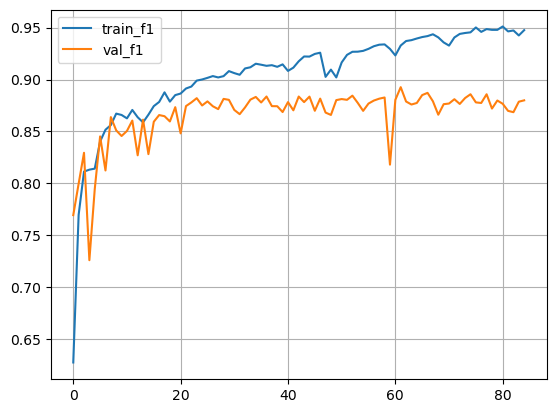

In [23]:
fig, ax = plt.subplots()
plt.plot(train.index, train['f1-score'])
plt.plot(val.index, val['f1-score'])
ax.legend(['train_f1', 'val_f1'])
plt.grid()
plt.show()

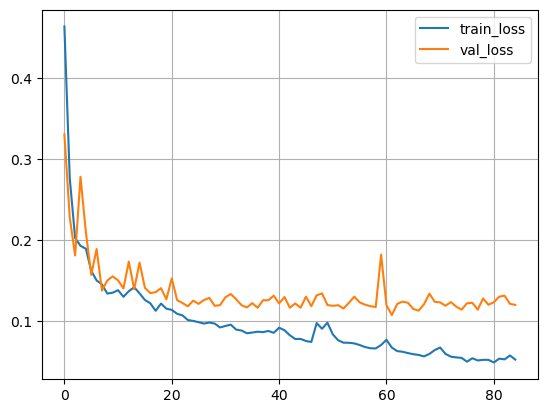

In [24]:
fig, ax = plt.subplots()
plt.plot(train.index, train['loss'])
plt.plot(val.index, val['loss'])
ax.legend(['train_loss', 'val_loss'])
plt.grid()
plt.show()